# 带上下文的多臂老虎机

在多臂老虎机问题中，并没有所谓的状态空间，只有动作空间。而在强化学习中，状态表示一个从环境中能获取到的信息集合，是一个非常重要的概念，下面通过结合上下文的多臂老虎机来说明这些概念。

In [9]:
import numpy as np
import random
import torch

下面实现一个简单的带上下文的多臂老虎机环境。其中为了保持问题简单，将状态数设置为和臂数一样。每次选择动作之后，会随机跳到任何一个状态（`update_state`）。

In [4]:
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()

    # number of states = number of arms
    # each row represents a state and each column an arm
    def init_distribution(self, arms):
        states = arms # just to keep things simple
        self.bandit_matrix = np.random.rand(states, arms)

    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if random.random() < prob:
                reward += 1
        return reward

    def get_state(self):
        return self.state

    def update_state(self):
        self.state = np.random.randint(0, self.arms)

    def get_reward(self, arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])

    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward


In [8]:
env = ContextBandit()
state = env.get_state()
reward = env.choose_arm(1)
print(env.bandit_matrix)
print(state, reward)

[[0.72811333 0.21967461 0.59982593 0.35118158 0.40646724 0.85505934
  0.44246246 0.42185671 0.80448018 0.71783342]
 [0.49196255 0.72353292 0.2488531  0.43972901 0.0633456  0.03640826
  0.64503795 0.95473732 0.81203962 0.68402456]
 [0.41152444 0.64801766 0.81399925 0.56150274 0.78833819 0.69355624
  0.25600998 0.6681032  0.95033076 0.12963515]
 [0.3853631  0.68981827 0.96547699 0.55050536 0.56031635 0.73965033
  0.96298104 0.4186984  0.47986107 0.47184021]
 [0.7690231  0.65929373 0.68338206 0.01840425 0.61157431 0.02953509
  0.28373152 0.74968103 0.55408933 0.65700551]
 [0.32060061 0.34702524 0.21970406 0.75807044 0.69746624 0.24840702
  0.888295   0.71677725 0.84246133 0.60615741]
 [0.60192371 0.21510572 0.29454412 0.75472882 0.84989392 0.36929953
  0.37194639 0.22559247 0.32780085 0.14865948]
 [0.1932369  0.25507141 0.3644076  0.20746941 0.81060608 0.32072809
  0.95685599 0.90250454 0.2893965  0.6101371 ]
 [0.48203529 0.36001941 0.35862841 0.54971164 0.00614207 0.74453629
  0.94396883

下图展示了整个学习流程的计算图。先通过 `env.get_state()` 获取当前状态，这是一个整数。将这个状态转换为 one-hot，然后输入网络。这个小型网络只有两层，第一层有 100 个单元，第二层则只有 10 个单元，输出为选择每个动作的收益分布，将这个收益经过 softmax 转化为概率分布，然后从这个概率分布中选择动作（收益越大概率越大）。选择动作之后，可以通过 `env` 获取到收益，将这个收益与网络输出计算损失，然后进行网络优化。

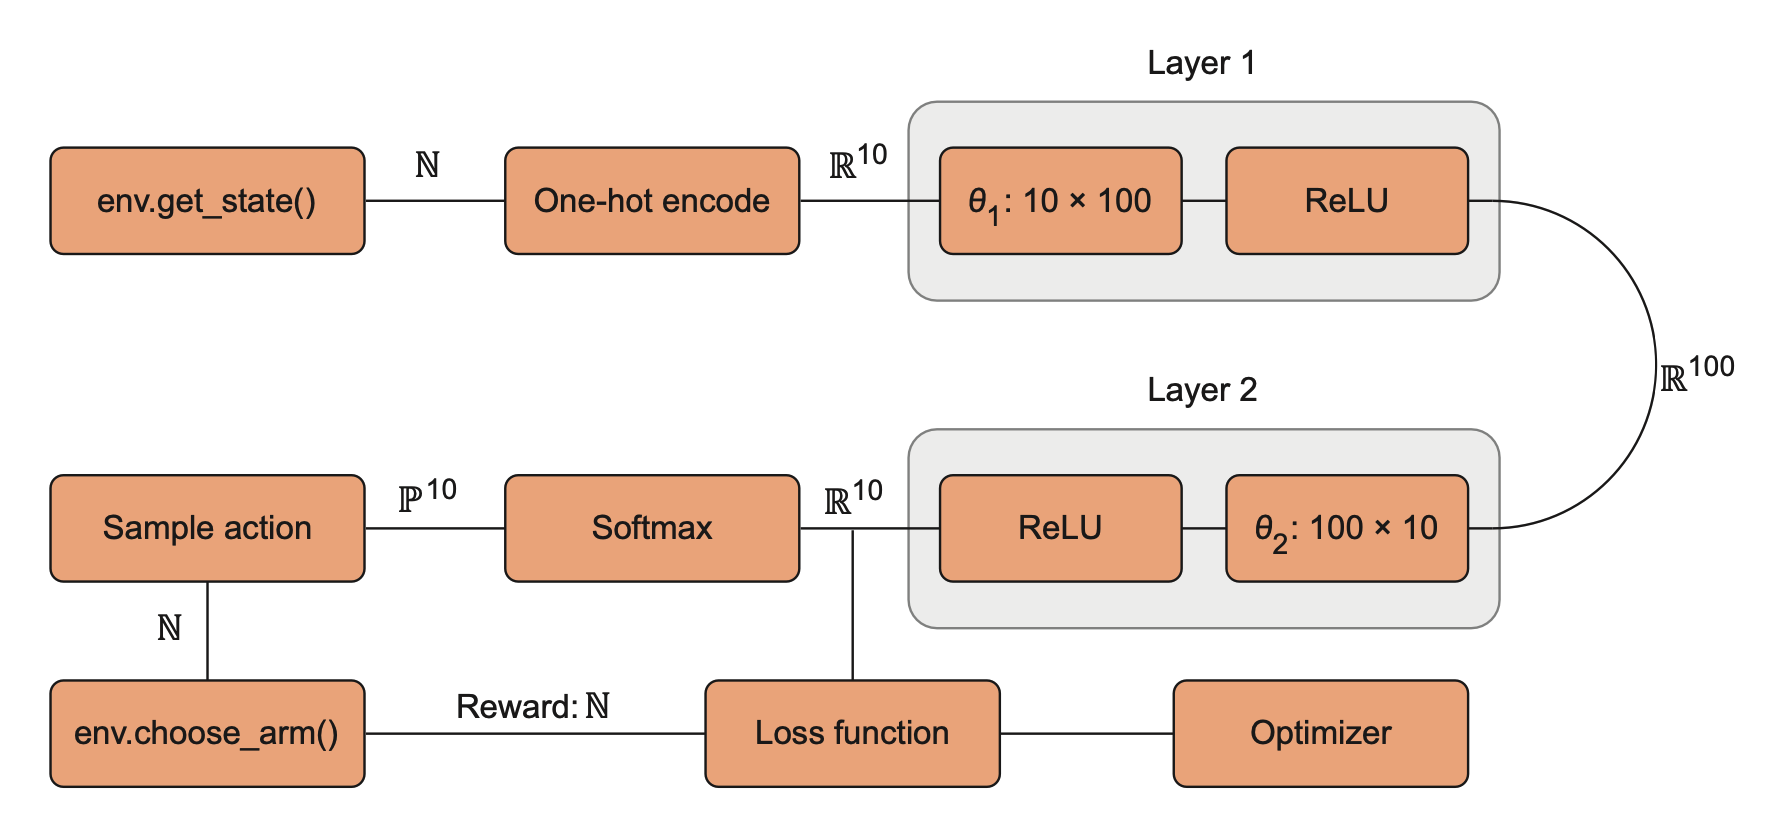

最开始，假设网络输出 `y_out = [1.4, 50, 4.3, 0.31, 0.43, 11, 121, 90, 8.9, 1.1]`，从中可以看到动作 6 对应收益 `121` 是最大的，于是选择动作 6，然后通过 `env` 我们得知实际收益为 80，那么此时我们就可以将**训练目标**设置为 `y_target = [1.4, 50, 4.3, 0.31, 0.43, 11, 80, 90, 8.9, 1.1]`, 通过 `diff = y_target - y_out` 作为损失函数（实际使用的是均方误差 MSE）进行梯度传播，优化网络。这样下次我们在当前状态选择动作 6 的时候，输出就会更趋向于 80。

In [10]:
arms = 10
N = 1 # batch size
D_in = arms # input dimension
H = 100 # size of hidden layer
D_out = arms

In [11]:
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU(),
)

loss_fn = torch.nn.MSELoss()

env = ContextBandit(arms)

In [13]:
def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec

def softmax(action_values, tau=1.12):
    exp = np.exp(action_values / tau)
    return exp / np.sum(exp)

In [14]:
def train(env, epochs=5000, learning_rate=1e-2):
    cur_state = torch.Tensor(one_hot(arms, env.get_state()))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    rewards = []
    for i in range(epochs):
        # use model to predict
        y_pred = model(cur_state)
        # transform predict to probability distribution by softmax
        av_softmax = softmax(y_pred.data.numpy(), tau=2.0)
        av_softmax /= av_softmax.sum()
        # make a choice
        choice = np.random.choice(arms, p=av_softmax)
        # transform reward to one hot and record
        cur_reward = env.choose_arm(choice)
        one_hot_reward = y_pred.data.numpy().copy()
        one_hot_reward[choice] = cur_reward
        reward = torch.Tensor(one_hot_reward)
        rewards.append(cur_reward)
        # calculate the loss and back propagation
        loss = loss_fn(y_pred, reward)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # update current state
        cur_state = torch.Tensor(one_hot(arms, env.get_state()))

    return np.array(rewards)

In [15]:
history = train(env)

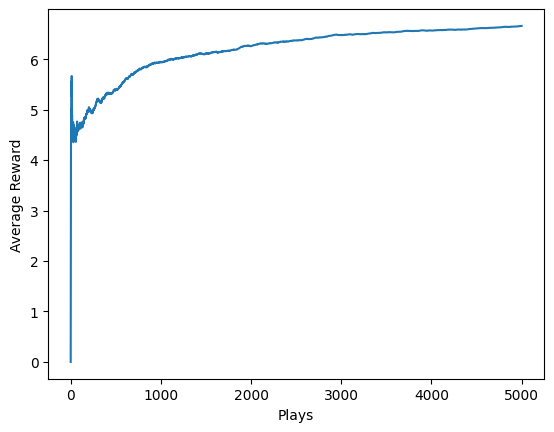

In [21]:
import matplotlib.pyplot as plt

moving_average = [0]
for i in range(len(history)):
    avg = ((i + 1) * moving_average[-1] + history[i]) / (i + 2)
    moving_average.append(avg)


plt.xlabel('Plays')
plt.ylabel('Average Reward')
plt.plot(np.arange(len(moving_average)), moving_average)